In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os.path
import biophysnn

from importlib import reload

In [3]:
from pathlib import Path
results_dir = Path("/gpfs/commons/home/daknowles/pooledRBPs/results/HNRNPK")

to_score = [ pd.read_csv(results_dir / ("beta_struct_rep%i.tsv.gz" % i), sep = "\t", index_col = False) for i 
       in range(2) ]

In [6]:
merged = to_score[0].merge(to_score[1], 
                           how = "outer",
                           on = ["contig", "position_hg19", "position", "variantID", "refAllele", "altAllele"], 
                           suffixes = ["_1","_2"])
merged

,contig,position_hg19,variantID,refAllele,altAllele,position,refCount_input_1,altCount_input_1,totalCount_input_1,pred_ratio_1,...,altCount_IP_2,totalCount_IP_2,shrunk_input_logratio_2,ase_loc_2,ase_sd_2,ase_q_2,shrunk_IP_logratio_2,asb_loc_2,asb_sd_2,asb_q_2
0,chr10,294953,rs1017361,A,G,249013,18.0,109.0,127.0,0.925054,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr10,320954,rs10903832,A,G,275014,98.0,24.0,122.0,0.191076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr10,325134,rs12357593,C,T,279194,10.0,4.0,14.0,0.214894,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr10,327780,rs7908298,C,T,281840,11.0,7.0,18.0,0.410334,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr10,347752,rs7918643,C,T,301812,12.0,9.0,21.0,0.302841,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385766,chr9,140656514,rs7032719,T,C,137762062,NaN,NaN,NaN,NaN,...,10.0,32.0,-0.313579,-0.001680,0.194389,0.496553,-0.481719,-0.168140,0.218887,0.221197
385767,chr9,140709605,rs67116066,A,G,137815153,NaN,NaN,NaN,NaN,...,5.0,77.0,-2.339802,-0.206415,0.209092,0.161773,-2.468830,-0.129028,0.323983,0.345221
385768,chr9,140709647,rs72766964,A,G,137815195,NaN,NaN,NaN,NaN,...,5.0,99.0,-2.363194,-0.209030,0.249279,0.200865,-2.821070,-0.457876,0.455280,0.157279
385769,chr9,140866826,rs12352971,G,T,137972374,NaN,NaN,NaN,NaN,...,22.0,65.0,-1.159956,0.275054,0.194685,0.078855,-0.909258,0.250697,0.212544,0.119098


In [9]:
import motifscanner
phys_net = motifscanner.PhysNet(torch.zeros(5,4,7), max_over_positions = False, max_over_motifs = False, seq_len = 600)
phys_net.load_state_dict(torch.load("checkpoints/posmax0_motifmax0_len600.pt"))

<All keys matched successfully>

In [10]:
genome = pickle.load(open("/gpfs/commons/home/daknowles/knowles_lab/index/hg38/hg38.pkl","rb")) # this is here in case there's hg38 data you want to analyse

In [16]:
np.mean([genome[merged.contig.iloc[i]][merged.position.iloc[i]-1] == merged.refAllele.iloc[i]for i in range(10000) ])

1.0

In [17]:
import pyximport;
pyximport.install(reload_support=True)
import seq_utils

In [20]:
list(range(0,22,4))

[0, 4, 8, 12, 16, 20]

In [27]:
strand_lookup = pd.read_csv("/gpfs/commons/home/mschertzer/asb_model/220708_all_ipsc_ip/ipsc_imputation_het_hg38_stranded.bed", 
                            sep = "\t", 
                            index_col = False, 
                            skiprows = 1, 
                            names = ["chrom","position","end","variantID","refAllele","strand"])
del strand_lookup["end"]
strand_lookup

In [42]:
strand_lookup

,chrom,position,variantID,refAllele,strand
0,chr10,45349,chr10:45349_G/A,G,+
1,chr10,45386,chr10:45386_T/G,T,+
2,chr10,60826,chr10:60826_C/A,C,+
3,chr10,60845,chr10:60845_G/A,G,+
4,chr10,73872,chr10:73872_C/T,C,+
...,...,...,...,...,...
31591121,chr9,135999503,rs116510425,G,-
31591122,chr9,135999633,rs115864487,G,-
31591123,chr9,135999653,rs535269131,C,-
31591124,chr9,135999659,rs778067980,C,-


In [43]:
snpdata = merged.rename(columns = {"contig" : "chrom"}
             ).merge(strand_lookup, 
                     on = ["chrom", "position","variantID","refAllele"])
snpdata

,chrom,position_hg19,variantID,refAllele,altAllele,position,refCount_input_1,altCount_input_1,totalCount_input_1,pred_ratio_1,...,totalCount_IP_2,shrunk_input_logratio_2,ase_loc_2,ase_sd_2,ase_q_2,shrunk_IP_logratio_2,asb_loc_2,asb_sd_2,asb_q_2,strand
0,chr10,294953,rs1017361,A,G,249013,18.0,109.0,127.0,0.925054,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,+
1,chr10,320954,rs10903832,A,G,275014,98.0,24.0,122.0,0.191076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-
2,chr10,325134,rs12357593,C,T,279194,10.0,4.0,14.0,0.214894,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-
3,chr10,327780,rs7908298,C,T,281840,11.0,7.0,18.0,0.410334,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-
4,chr10,347752,rs7918643,C,T,301812,12.0,9.0,21.0,0.302841,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385766,chr9,140656514,rs7032719,T,C,137762062,NaN,NaN,NaN,NaN,...,32.0,-0.313579,-0.001680,0.194389,0.496553,-0.481719,-0.168140,0.218887,0.221197,+
385767,chr9,140709605,rs67116066,A,G,137815153,NaN,NaN,NaN,NaN,...,77.0,-2.339802,-0.206415,0.209092,0.161773,-2.468830,-0.129028,0.323983,0.345221,+
385768,chr9,140709647,rs72766964,A,G,137815195,NaN,NaN,NaN,NaN,...,99.0,-2.363194,-0.209030,0.249279,0.200865,-2.821070,-0.457876,0.455280,0.157279,+
385769,chr9,140866826,rs12352971,G,T,137972374,NaN,NaN,NaN,NaN,...,65.0,-1.159956,0.275054,0.194685,0.078855,-0.909258,0.250697,0.212544,0.119098,+


1.0

In [128]:
context_length = phys_net.seq_len
batchsize = 100
output_nonlin = torch.sigmoid
device = "cuda:0" if torch.cuda.is_available() else "cpu"
phys_net.to(device)
def get_batch(starti, flip_to_alt):
    def get_oh(i): 
        midpoint = snpdata.position.iloc[i]-1
        seq = genome[snpdata.chrom.iloc[i]][ midpoint - context_length//2:midpoint + context_length//2]
        #assert(seq[context_length//2] == snpdata.refAllele.iloc[i])
        if flip_to_alt: 
            seq = seq[:context_length//2] + snpdata.altAllele.iloc[i] + seq[context_length//2+1:]
            #assert(seq[context_length//2] == snpdata.altAllele.iloc[i])
        if snpdata.strand.iloc[i] == "-": seq = seq_utils.reverse_complement(seq)
        return seq_utils.one_hot(seq)
    endi = min(starti+batchsize, len(snpdata))
    batch = [get_oh(i) for i in range(starti, endi)]
    x = np.dstack(batch).transpose([2,0,1])
    return torch.tensor(x, device = device)

ref_probs = []
alt_probs = []
for i in range(0,snpdata.shape[0],batchsize): # range(0,1000,batchsize):
    print("%i out of %i" % (i, snpdata.shape[0]), end = "\r")
    x_ref = get_batch(i, False)
    o_ref = output_nonlin(phys_net(x_ref))
    x_alt = get_batch(i, True)
    o_alt = output_nonlin(phys_net(x_alt))
    ref_probs.append(o_ref.detach().cpu().numpy())
    alt_probs.append(o_alt.detach().cpu().numpy())
ref_probs = np.concatenate(ref_probs)
alt_probs = np.concatenate(alt_probs)

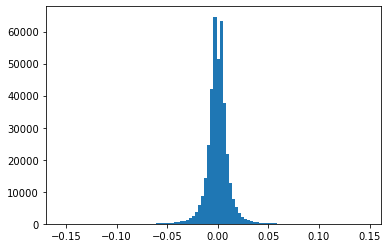

In [149]:
plt.hist( alt_probs - ref_probs, 100 )
plt.show()

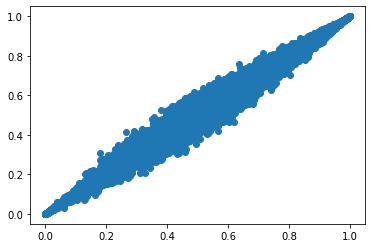

In [150]:
plt.scatter(ref_probs, alt_probs)

In [151]:
snpdata["vep"] = alt_probs - ref_probs

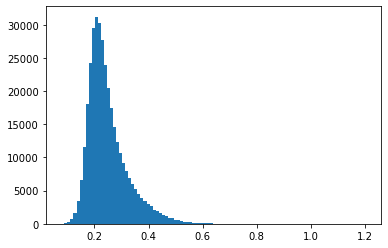

In [169]:
_ = plt.hist(snpdata.asb_sd_1,100)

In [153]:
keep = ~snpdata.asb_loc_1.isna() & ~snpdata.asb_loc_2.isna()
shared = snpdata[keep]

Text(0.5, 1.0, 'R=0.024, p=6e-29')

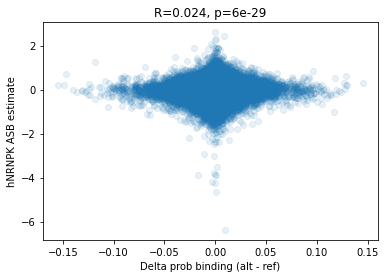

In [176]:
import seaborn as sns
plt.scatter(shared.vep, shared.asb_loc_1 + shared.asb_loc_2, alpha=0.1)
(R,p) = scipy.stats.pearsonr( shared.vep, shared.asb_loc_1 + shared.asb_loc_2 )
plt.xlabel("Delta prob binding (alt - ref)")
plt.ylabel("hNRNPK ASB estimate")
plt.title("R=%.3f, p=%.1g" % (R,p))

(0.024274170789995803, 5.54619764874797e-29)

In [170]:
scipy.stats.spearmanr( shared.vep, shared.asb_loc_1 + shared.asb_loc_2 )

SpearmanrResult(correlation=0.024725273444052957, pvalue=5.235697263302409e-30)

In [161]:
rep1_asb = ( (snpdata.altCount_IP_1+0.5) / (snpdata.altCount_input_1+0.5)) / ((snpdata.refCount_IP_1+0.5) / (snpdata.refCount_input_1+0.5))
rep2_asb = ( (snpdata.altCount_IP_2+0.5) / (snpdata.altCount_input_2+0.5)) / ((snpdata.refCount_IP_2+0.5) / (snpdata.refCount_input_2+0.5))
asb = .5 * (rep1_asb + rep2_asb)

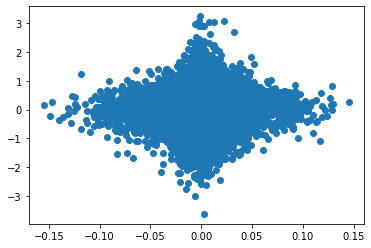

In [162]:
log_asb = np.log(asb) 
plt.scatter( alt_probs - ref_probs, log_asb )

In [163]:
keep = ~log_asb.isna() & ~np.isinf(log_asb)
scipy.stats.pearsonr( vep[keep], log_asb[keep] )

(0.024009398525659198, 2.172499484464552e-28)

In [142]:
np.isinf(log_asb[keep]).any()

True

## Break down by gene region

In [178]:
snpinfo = pd.read_csv("/gpfs/commons/home/mschertzer/asb_model/220708_all_ipsc_ip/220823_all_testable_snp_info_table.txt", 
                            sep = "\t", 
                            index_col = False)
snpinfo


,snp_chr,snp_start,snp_end,snp_id,distance_to_peak,peak_chr,peak_start,peak_end,peak_id,peak_score,...,pred_ratio,shrunk_input_logratio,ase_loc,ase_sd,ase_q,shrunk_IP_logratio,asb_loc,asb_sd,asb_q,gene_feature
0,chr18,49054943,49054944,rs1000055,168,chr18,49054773,49054774,all_hnrnpk_rep1_neg_peak_31164,241,...,0.453158,-0.211443,-0.023522,0.157609,0.440682,-0.301231,-0.089789,0.208681,0.333501,Intron
1,chr4,113625533,113625534,rs10000775,5535,chr4,113619996,113619997,all_hnrnpk_rep1_neg_peak_52145,42,...,0.466136,-0.250126,-0.114462,0.181879,0.264566,-0.194114,0.056013,0.200520,0.389993,Intron
2,chr4,38691214,38691215,rs1000096,10,chr4,38691226,38691227,all_hnrnpk_rep1_pos_peak_54546,25,...,0.379920,-0.226619,0.263270,0.164275,0.054509,-0.363252,-0.136633,0.184821,0.229870,Intron
3,chr4,110056974,110056975,rs10001138,82,chr4,110057058,110057059,all_hnrnpk_rep1_neg_peak_52093,68,...,0.232882,-1.147026,0.045082,0.211588,0.415639,-1.092259,0.054767,0.226932,0.404647,Intron
4,chr4,4732192,4732193,rs10001497,806,chr4,4733000,4733001,all_hnrnpk_rep1_pos_peak_53927,31,...,0.097733,-2.055520,0.167154,0.273043,0.270206,-1.917222,0.138298,0.279190,0.310175,Intron
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61580,chr4,16999983,16999984,rs9998880,769,chr4,16999212,16999213,all_hnrnpk_rep1_pos_peak_54282,274,...,0.635265,1.168572,0.613702,0.193222,0.000746,1.419558,0.250985,0.192575,0.096234,Intron
61581,chr9,7133798,7133799,rs999931,47,chr9,7133749,7133750,all_hnrnpk_rep1_pos_peak_71505,98,...,0.165388,-1.400440,0.218233,0.205501,0.144127,-1.304886,0.095553,0.227351,0.337137,Intron
61582,chr7,33824457,33824458,rs999938,191,chr7,33824650,33824651,all_hnrnpk_rep1_pos_peak_65265,53,...,0.314227,-0.817336,-0.036904,0.181115,0.419271,-0.765201,0.052135,0.176713,0.383988,Intron
61583,chr18,10710532,10710533,rs999954,21,chr18,10710509,10710510,all_hnrnpk_rep1_neg_peak_30224,17,...,0.294529,-0.909114,-0.035627,0.233097,0.439261,-0.867431,0.041683,0.206846,0.420147,Intron


In [179]:
snpinfo.columns

Index(['snp_chr', 'snp_start', 'snp_end', 'snp_id', 'distance_to_peak',
       'peak_chr', 'peak_start', 'peak_end', 'peak_id', 'peak_score',
       'peak_strand', 'log_odds_max.mcross_alt', 'log_odds_max.mcross_ref',
       'odds.mcross_alt', 'odds.mcross_ref', 'prob.mcross_alt',
       'prob.mcross_ref', 'log_odds_max.oRNA_alt', 'log_odds_max.oRNA_ref',
       'odds.oRNA_alt', 'odds.oRNA_ref', 'prob.oRNA_alt', 'prob.oRNA_ref',
       'chr', 'position', 'pred_ratio', 'shrunk_input_logratio', 'ase_loc',
       'ase_sd', 'ase_q', 'shrunk_IP_logratio', 'asb_loc', 'asb_sd', 'asb_q',
       'gene_feature'],
      dtype='object')

In [181]:
snpinfo

,snp_chr,snp_start,snp_end,snp_id,distance_to_peak,peak_chr,peak_start,peak_end,peak_id,peak_score,...,pred_ratio,shrunk_input_logratio,ase_loc,ase_sd,ase_q,shrunk_IP_logratio,asb_loc,asb_sd,asb_q,gene_feature
0,chr18,49054943,49054944,rs1000055,168,chr18,49054773,49054774,all_hnrnpk_rep1_neg_peak_31164,241,...,0.453158,-0.211443,-0.023522,0.157609,0.440682,-0.301231,-0.089789,0.208681,0.333501,Intron
1,chr4,113625533,113625534,rs10000775,5535,chr4,113619996,113619997,all_hnrnpk_rep1_neg_peak_52145,42,...,0.466136,-0.250126,-0.114462,0.181879,0.264566,-0.194114,0.056013,0.200520,0.389993,Intron
2,chr4,38691214,38691215,rs1000096,10,chr4,38691226,38691227,all_hnrnpk_rep1_pos_peak_54546,25,...,0.379920,-0.226619,0.263270,0.164275,0.054509,-0.363252,-0.136633,0.184821,0.229870,Intron
3,chr4,110056974,110056975,rs10001138,82,chr4,110057058,110057059,all_hnrnpk_rep1_neg_peak_52093,68,...,0.232882,-1.147026,0.045082,0.211588,0.415639,-1.092259,0.054767,0.226932,0.404647,Intron
4,chr4,4732192,4732193,rs10001497,806,chr4,4733000,4733001,all_hnrnpk_rep1_pos_peak_53927,31,...,0.097733,-2.055520,0.167154,0.273043,0.270206,-1.917222,0.138298,0.279190,0.310175,Intron
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61580,chr4,16999983,16999984,rs9998880,769,chr4,16999212,16999213,all_hnrnpk_rep1_pos_peak_54282,274,...,0.635265,1.168572,0.613702,0.193222,0.000746,1.419558,0.250985,0.192575,0.096234,Intron
61581,chr9,7133798,7133799,rs999931,47,chr9,7133749,7133750,all_hnrnpk_rep1_pos_peak_71505,98,...,0.165388,-1.400440,0.218233,0.205501,0.144127,-1.304886,0.095553,0.227351,0.337137,Intron
61582,chr7,33824457,33824458,rs999938,191,chr7,33824650,33824651,all_hnrnpk_rep1_pos_peak_65265,53,...,0.314227,-0.817336,-0.036904,0.181115,0.419271,-0.765201,0.052135,0.176713,0.383988,Intron
61583,chr18,10710532,10710533,rs999954,21,chr18,10710509,10710510,all_hnrnpk_rep1_neg_peak_30224,17,...,0.294529,-0.909114,-0.035627,0.233097,0.439261,-0.867431,0.041683,0.206846,0.420147,Intron


In [186]:
wgenefeature = snpdata.merge(snpinfo.loc[:,["snp_chr", "snp_start", "snp_end", "snp_id", "distance_to_peak", "peak_chr", "peak_start",	"peak_score", "gene_feature"]]
              .rename(columns = {"snp_chr":"chrom","snp_start":"position", "snp_id":"variantID"}), 
              on = ["chrom","position", "variantID"])

In [187]:
wgenefeature

,chrom,position_hg19,variantID,refAllele,altAllele,position,refCount_input_1,altCount_input_1,totalCount_input_1,pred_ratio_1,...,asb_sd_2,asb_q_2,strand,vep,snp_end,distance_to_peak,peak_chr,peak_start,peak_score,gene_feature
0,chr10,347752,rs7918643,C,T,301812,12.0,9.0,21.0,0.302841,...,NaN,NaN,-,0.029674,301813,599,chr10,301211,220,Intron
1,chr10,353589,rs11251600,T,C,307649,7.0,4.0,11.0,0.302841,...,NaN,NaN,-,-0.002175,307650,160,chr10,307811,351,Intron
2,chr10,354018,rs3123229,T,C,308078,5.0,6.0,11.0,0.698550,...,NaN,NaN,-,-0.002371,308079,265,chr10,307811,351,Intron
3,chr10,390318,rs4881153,A,G,344378,4.0,8.0,12.0,0.707038,...,NaN,NaN,-,0.001609,344379,265,chr10,344111,127,Intron
4,chr10,407584,rs3922851,G,A,361644,8.0,11.0,19.0,0.319375,...,0.303972,0.494715,-,-0.006992,361645,157,chr10,361485,27,Intron
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61580,chr9,140998976,rs62579478,G,A,138104524,7.0,8.0,15.0,0.341681,...,0.206312,0.487468,+,0.004537,138104525,2188,chr9,138102334,181,Intron
61581,chr9,140999200,rs62579480,G,A,138104748,10.0,10.0,20.0,0.341681,...,0.199904,0.286699,+,0.021934,138104749,2412,chr9,138102334,181,Intron
61582,chr9,141001147,rs113447687,C,T,138106695,7.0,5.0,12.0,0.305868,...,NaN,NaN,+,-0.000718,138106696,4359,chr9,138102334,181,Intron
61583,chr9,141001866,rs10867107,T,C,138107414,24.0,5.0,29.0,0.254254,...,0.211068,0.451006,+,0.001735,138107415,4699,chr9,138112115,192,Intron


In [188]:
keep = ~wgenefeature.asb_loc_1.isna() & ~wgenefeature.asb_loc_2.isna()
shared = wgenefeature[keep]

Text(0.5, 1.0, 'R=0.021, p=3e-05')

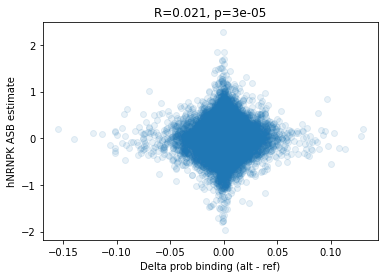

In [189]:
plt.scatter(shared.vep, shared.asb_loc_1 + shared.asb_loc_2, alpha=0.1)
(R,p) = scipy.stats.pearsonr( shared.vep, shared.asb_loc_1 + shared.asb_loc_2 )
plt.xlabel("Delta prob binding (alt - ref)")
plt.ylabel("hNRNPK ASB estimate")
plt.title("R=%.3f, p=%.1g" % (R,p))

array(['Intron', '3UTR', 'Exon'], dtype=object)

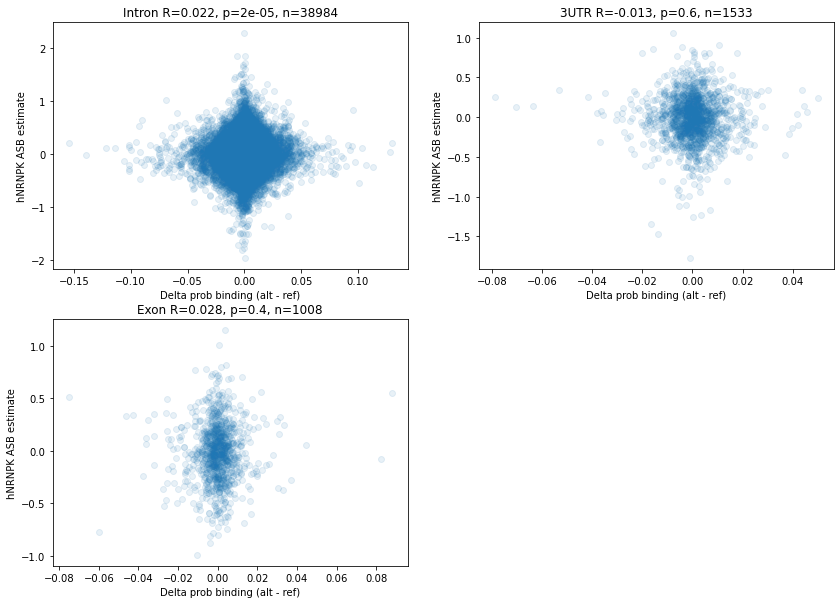

In [203]:
plt.figure(figsize=(14,10))
for i,gf in enumerate(shared.gene_feature.unique()):
    plt.subplot(2,2,i+1)
    sub = shared[shared.gene_feature == gf]
    plt.scatter(sub.vep, sub.asb_loc_1 + sub.asb_loc_2, alpha=0.1)
    (R,p) = scipy.stats.pearsonr( sub.vep, sub.asb_loc_1 + sub.asb_loc_2 )
    plt.xlabel("Delta prob binding (alt - ref)")
    plt.ylabel("hNRNPK ASB estimate")
    plt.title("%s R=%.3f, p=%.1g, n=%i" % (gf,R,p,len(sub)))

In [ ]:
import papermill

In [16]:
import sys
!conda install --yes --prefix {sys.prefix} -c conda-forge nbclient==0.6.7

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.14.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /gpfs/commons/home/daknowles/.conda/envs/asb

  added / updated specs:
    - nbclient==0.6.7


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    nbclient-0.6.7             |     pyhd8ed1ab_0          65 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          65 KB

The following packages will be UPDATED:

  nbclient                              0.5.11-pyhd8ed1ab_0 --> 0.6.7-pyhd8ed1ab_0



nbclient-0.6.7       | 65 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [24]:
import nbclient

ImportError: cannot import name 'Callable' from 'traitlets' (/gpfs/commons/home/daknowles/.conda/envs/asb/lib/python3.8/site-packages/traitlets/__init__.py)

In [ ]:
!conda update -n base conda

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/linux-64::conda==4.10.3=py37h89c1867_2
  - defaults/linux-64::numpydoc==0.8.0=py37_0
  - defaults/linux-64::path.py==11.5.0=py37_0
  - defaults/linux-64::conda-build==3.17.8=py37_0
  - defaults/linux-64::spyder==3.3.3=py37_0
  - defaults/linux-64::anaconda-client==1.7.2=py37_0
  - defaults/linux-64::_anaconda_depends==2019.07=py37_0
  - defaults/linux-64::sphinx==1.8.5=py37_0
  - defaults/linux-64::anaconda-project==0.8.2=py37_0
  - conda-forge/linux-64::mamba==0.1.2=py37h99015e2_0
  - defaults/linux-64::anaconda-navigator==1.9.7=py37_0
  - defaults/linux-64::anaconda==custom=py37_1
/ 

In [29]:
1

1

In [26]:
1

1

In [28]:
import torch

/gpfs/commons/home/daknowles/.conda/envs/asb/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
